In [1]:
!pip install -qU langchain\
    langchain-community\
    langchain-together\
    langchain-core\
    faiss-cpu\
    faiss-gpu\
    langgraph\
    sentence-transformers\
    gradio\
    requests\
    beautifulsoup4\
    unstructured[pdf]\
    langchain-huggingface\
    rank_bm25\
    tavily-python

!pip install langgraph

^C


ERROR: Could not find a version that satisfies the requirement faiss-gpu (from versions: none)
ERROR: No matching distribution found for faiss-gpu

[notice] A new release of pip is available: 23.3.2 -> 24.1.1
[notice] To update, run: C:\Users\ali18\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


  Using cached langchain_core-0.2.17-py3-none-any.whl.metadata (6.0 kB)
   ---------------------------------------- 0.0/91.4 kB ? eta -:--:--
   ------------- -------------------------- 30.7/91.4 kB 660.6 kB/s eta 0:00:01
   ----------------- ---------------------- 41.0/91.4 kB 393.8 kB/s eta 0:00:01
   ---------------------------------------- 91.4/91.4 kB 744.3 kB/s eta 0:00:00
   ---------------------------------------- 0.0/366.1 kB ? eta -:--:--
   ---------- ----------------------------- 92.2/366.1 kB 2.6 MB/s eta 0:00:01
   ------------- -------------------------- 122.9/366.1 kB 1.8 MB/s eta 0:00:01
   ------------------------- -------------- 235.5/366.1 kB 1.8 MB/s eta 0:00:01
   ---------------------------------------- 366.1/366.1 kB 2.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/127.9 kB ? eta -:--:--
   ---------------------------------------- 127.9/127.9 kB 3.7 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.3.2 -> 24.1.1
[notice] To update, run: C:\Users\ali18\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
import requests
import re
import os.path
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from textwrap import dedent

from langchain_community.document_loaders import OnlinePDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain.storage import LocalFileStore
from langchain.embeddings import CacheBackedEmbeddings
from langchain.retrievers import EnsembleRetriever
from langchain_community.retrievers import BM25Retriever
from langchain_together import ChatTogether
from langchain.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.documents import Document
from langchain_core.messages.base import BaseMessage
from langgraph.graph import StateGraph, END
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain.output_parsers import PydanticOutputParser
from langchain.utilities.tavily_search import TavilySearchAPIWrapper
from langchain.tools.tavily_search import TavilySearchResults
from langchain_core.runnables import chain
from langchain_core.documents.base import Document
from langchain_core.output_parsers import StrOutputParser

from IPython.display import Image, display
from IPython.core.display import Markdown

from typing import Literal, TypedDict

In [ ]:
os.environ["TAVILY_API_KEY"] = "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"
os.environ["TOGETHER_API_KEY"] = "9f24f1264668e13d395b5f214fce62f405544086d879b3fa954b5578de15b72d"

## Part 1 - Receiving and Preparing Data

In [ ]:
def scrap_and_get_links(url):
    response = requests.get(url)
    if response.status_code != 200:
        print("Failed scrap")
        return None
    html_content = response.content
    soup = BeautifulSoup(html_content, 'html.parser')
    all_hrefs = soup.find_all('a', href=True)
    pdf_hrefs = [link['href'] for link in all_hrefs if re.search(r'^\d+\.pdf$', link['href'])]
    links = [urljoin(url, link) for link in pdf_hrefs]
    print("Success scrap")
    return links

In [ ]:
url = 'https://stanford.edu/~jurafsky/slp3/'
links = scrap_and_get_links(url)

Success scrap


In [ ]:
documents = []
for link in links:
    online_pdf_loader = OnlinePDFLoader(link)
    documents.extend(online_pdf_loader.load())

In [ ]:
documents

In [7]:
recursive_character_text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1024,
    chunk_overlap=64,
    length_function=len
)

chunks = recursive_character_text_splitter.split_documents(documents)

## Part 2 - Vector Embedding and Database Generation


In [8]:
store = LocalFileStore('./cache/')
general_embedding = HuggingFaceEmbeddings()
embeddings = CacheBackedEmbeddings.from_bytes_store(
    general_embedding,
    store
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [9]:
def load_faiss_vector_store(embeddings_db_name):
    if not os.path.isfile(embeddings_db_name):
        faiss_vector_store = FAISS.from_documents(chunks, embeddings)
        faiss_vector_store.save_local(embeddings_db_name)
    else:
        faiss_vector_store = FAISS.load_local(embeddings_db_name)

    return faiss_vector_store

In [10]:
faiss_vector_store = load_faiss_vector_store(
    embeddings_db_name="faiss_index"
)

print(faiss_vector_store.index.ntotal)

2122


## Part 3 - Implementing Semantic and Lexical Retrievers

In [11]:
bm25_term_saturation = 4
bm25_retriever = BM25Retriever.from_texts(
    [chunk.page_content for chunk in chunks]
)

bm25_retriever.k = bm25_term_saturation

In [12]:
faiss_term_saturation = 4
faiss_retriever = faiss_vector_store.as_retriever(
    search_kwargs={'k': faiss_term_saturation}
)

In [13]:
related_query = "Named Entity Recognizers"
unrelated_query = "Cloud Computing"
super_unrelated_query = "Champion of Asian cup"

In [14]:
print(faiss_retriever.invoke(related_query))
print(faiss_retriever.invoke(unrelated_query))
print(faiss_retriever.invoke(super_unrelated_query))

[Document(metadata={'source': '/tmp/tmpz3h9atcu/tmp.pdf'}, page_content='named entity\n\nnamed entity recognition NER\n\nA named entity is, roughly speaking, anything that can be referred to with a proper name: a person, a location, an organization. The task of named entity recog- nition (NER) is to ﬁnd spans of text that constitute proper names and tag the type of the entity. Four entity tags are most common: PER (person), LOC (location), ORG (organization), or GPE (geo-political entity). However, the term named entity is commonly extended to include things that aren’t entities per se, including dates, times, and other kinds of temporal expressions, and even numerical expressions like prices. Here’s an example of the output of an NER tagger:'), Document(metadata={'source': '/tmp/tmpz3h9atcu/tmp.pdf'}, page_content='8.6 Evaluation of Named Entity Recognition\n\nPart-of-speech taggers are evaluated by the standard metric of accuracy. Named entity recognizers are evaluated by recall, pre

In [15]:
print(bm25_retriever.invoke(related_query))
print(bm25_retriever.invoke(unrelated_query))
print(bm25_retriever.invoke(super_unrelated_query))

[Document(page_content='8.5.2 Features for CRF Named Entity Recognizers\n\nA CRF for NER makes use of very similar features to a POS tagger, as shown in Figure 8.15.\n\nidentity of wi, identity of neighboring words embeddings for wi, embeddings for neighboring words part of speech of wi, part of speech of neighboring words presence of wi in a gazetteer wi contains a particular preﬁx (from all preﬁxes of length ≤ 4) wi contains a particular sufﬁx (from all sufﬁxes of length ≤ 4) word shape of wi, word shape of neighboring words short word shape of wi, short word shape of neighboring words gazetteer features Figure 8.15 Typical features for a feature-based NER system.'), Document(page_content='The known-word templates are computed for every word seen in the training set; the unknown word features can also be computed for all words in training, or only on training words whose frequency is below some threshold. The result of the known-word templates and word-signature features is a very la

In [16]:
def build_ensemble_retriever(wights):
    return EnsembleRetriever(
        retrievers=[bm25_retriever, faiss_retriever], wights=wights
    )

def test_ensemble_retriever(wights):
    ensemble_retriever = build_ensemble_retriever(wights)
    print(f"for {wights}:")
    print(ensemble_retriever.invoke(related_query))
    print(ensemble_retriever.invoke(unrelated_query))
    print(ensemble_retriever.invoke(super_unrelated_query))
    print("\n")

In [17]:
test_ensemble_retriever([0.5, 0.5])
test_ensemble_retriever([0.1, 0.9])
test_ensemble_retriever([0.9, 0.1])

for [0.5, 0.5]:
[Document(page_content='8.5.2 Features for CRF Named Entity Recognizers\n\nA CRF for NER makes use of very similar features to a POS tagger, as shown in Figure 8.15.\n\nidentity of wi, identity of neighboring words embeddings for wi, embeddings for neighboring words part of speech of wi, part of speech of neighboring words presence of wi in a gazetteer wi contains a particular preﬁx (from all preﬁxes of length ≤ 4) wi contains a particular sufﬁx (from all sufﬁxes of length ≤ 4) word shape of wi, word shape of neighboring words short word shape of wi, short word shape of neighboring words gazetteer features Figure 8.15 Typical features for a feature-based NER system.'), Document(metadata={'source': '/tmp/tmpz3h9atcu/tmp.pdf'}, page_content='named entity\n\nnamed entity recognition NER\n\nA named entity is, roughly speaking, anything that can be referred to with a proper name: a person, a location, an organization. The task of named entity recog- nition (NER) is to ﬁnd sp

## Part 4 - Implementing Router Chain

In [18]:
router_prompt_template = \
    """
    Your task is to categorize user quiries into one of three categories: VectorStore, SearchEngine, or None.
    Select VectorStore for questions related to Natural Language Processing or Speech Processing.
    Choose SearchEngine for inquiries about computer science topics not involving NLP.
    Opt for None if the question does not pertain to NLP or Computer Science.
    Provide only the selected category as your response. Do not include any additional information.
    {output_instruction}
    query: {query}
    """


In [19]:
router_prompt_template = dedent(router_prompt_template)

router_prompt = ChatPromptTemplate.from_template(
    template=router_prompt_template
)

router_llm = ChatTogether(
    together_api_key=os.environ["TOGETHER_API_KEY"],
    model="meta-llama/Llama-3-70b-chat-hf",
    temperature=0.0
)

class QueryType(BaseModel):
    class_name: Literal["None", "SearchEngine", "VectorStore"] = Field()

router_parser = PydanticOutputParser(pydantic_object=QueryType)

In [20]:
# for test
router_prompt.invoke({
    "query": "What is NLI?",
    "output_instruction": router_parser.get_format_instructions()
})

ChatPromptValue(messages=[HumanMessage(content='\nYour task is to categorize user quiries into one of three categories: VectorStore, SearchEngine, or None.\nSelect VectorStore for questions related to Natural Language Processing or Speech Processing.\nChoose SearchEngine for inquiries about computer science topics not involving NLP.\nOpt for None if the question does not pertain to NLP or Computer Science.\nProvide only the selected category as your response. Do not include any additional information.\nThe output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"class_name": {"ti

In [21]:
router_chain = router_prompt | router_llm | router_parser

In [22]:
def test_router_chain(query):
    return router_chain.invoke({
        "query": query,
        "output_instruction": router_parser.get_format_instructions()
    })

print(
    f"related_query: {test_router_chain('What are the main uses of Named Entity Recognizers?')}\n"
    f"unrelated_query: {test_router_chain('Who are the top providers of cloud computing services?')}\n"
    f"super_unrelated_query: {test_router_chain('Which teams have won the most Asian Cup titles?')}\n"
)

related_query: class_name='VectorStore'
unrelated_query: class_name='SearchEngine'
super_unrelated_query: class_name='None'



## Part 5 - Implementing Search Engine Chain


In [23]:
tavily_search_wrapper = TavilySearchAPIWrapper(tavily_api_key=os.environ["TAVILY_API_KEY"])
tavily_search = TavilySearchResults(api_wrapper=tavily_search_wrapper, max_results=5)

In [24]:
tavily_search.invoke("What are the latest advancements in NLP for improving sentiment analysis?")

[{'url': 'https://www.sciencedirect.com/science/article/pii/S2949719124000074',
  'content': 'Natural Language Processing Journal\nRecent advancements and challenges of NLP-based sentiment analysis: A state-of-the-art review\nAbstract\nSentiment analysis is a method within natural language processing that evaluates and identifies the emotional tone or mood conveyed in textual data. This extensive review provides a complete understanding of sentiment analysis, covering its models, application domains, results analysis, challenges, and research directions.\n Therefore, in this extensive survey, we began exploring the vast array of application domains for sentiment analysis, scrutinizing them within the context of existing research. The significance of sentiment analysis lies in its capacity to derive valuable insights from extensive textual data, empowering businesses to grasp customer sentiments, make informed choices, and enhance their offerings. For the further advancement of sentimen

In [25]:
@chain
def parse_tavily_search(documents):
    return [Document(
              page_content=doc['content'],
              metadata={'url': doc['url']}
            ) for doc in documents]

    return result_documents

In [26]:
search_engine_chain = tavily_search | parse_tavily_search

In [27]:
search_engine_chain.invoke("What are the latest advancements in NLP for improving sentiment analysis?")

[Document(metadata={'url': 'https://www.sciencedirect.com/science/article/pii/S2949719124000074'}, page_content='Natural Language Processing Journal\nRecent advancements and challenges of NLP-based sentiment analysis: A state-of-the-art review\nAbstract\nSentiment analysis is a method within natural language processing that evaluates and identifies the emotional tone or mood conveyed in textual data. This extensive review provides a complete understanding of sentiment analysis, covering its models, application domains, results analysis, challenges, and research directions.\n Therefore, in this extensive survey, we began exploring the vast array of application domains for sentiment analysis, scrutinizing them within the context of existing research. The significance of sentiment analysis lies in its capacity to derive valuable insights from extensive textual data, empowering businesses to grasp customer sentiments, make informed choices, and enhance their offerings. For the further adva

## Part 6 - Implementing Relevancy Check Chain


In [28]:
relevancy_check_template = \
"""You are provided with a user question and a document. If the given document is relevant to the user question and can be used to answer it, output 'Relevant', and if not, output 'Irrelevant'. Only output the words Relevant and Irrelevant in a JSON format as described in the output instructions.
User question: {user_query}
Document: {retrieved_document}
Output instruction: {output_instruction}
"""


In [29]:
relevancy_check_template = dedent(relevancy_check_template)
relevancy_check_prompt = ChatPromptTemplate.from_template(
    template=relevancy_check_template
)

relevancy_check_llm = ChatTogether(
    together_api_key=os.environ["TOGETHER_API_KEY"],
    model="meta-llama/Llama-3-70b-chat-hf",
    temperature=0
)

class RelevancyType(BaseModel):
    class_name: Literal["Relevant", "Irrelevant"] = Field()

relevancy_check_parser = PydanticOutputParser(pydantic_object=RelevancyType)

In [30]:
relevancy_check = relevancy_check_prompt | relevancy_check_llm | relevancy_check_parser

In [31]:
def test_relevancy_check(query, document=None):
    if document == None:
        document = search_engine_chain.invoke(query)[0]

    result = relevancy_check.invoke({
        "user_query": query,
        "retrieved_document": document,
        "output_instruction": relevancy_check_parser.get_format_instructions()
    })

    if result.class_name == 'Irrelevant':
        print('Irrelevant query')
        return result

    print(f'Retrieved Document: {document}')
    return result, document

In [32]:
result, result_document = test_relevancy_check("What are the main uses of Named Entity Recognizers?")
result

Retrieved Document: page_content='Using the previous example, “Goth” will be recognized as a last name rather than a subculture since the identification process determined it to be a proper noun and the classification process placed it under the category of “person.”
 You must create the rules based on two types of instruction: pattern-based rules, which relate to word forms and structure, and context-based rules like “if a contraction such as Mr. or Ms. precedes a name, then that contraction is the person’s honorific title.” Pros and cons of using named entity recognition systems
Learn more about named entity recognition with Coursera
You can strengthen your knowledge of natural language processing with expert-level guidance on Coursera. Coursera Footer
Popular AI Content
Popular Programs
Popular Skills
Popular Career Resources
Coursera
Community
More Breaking this term down into two parts can help us better understand it:
Named Entity: A named entity is any object that can be referen

RelevancyType(class_name='Relevant')

In [33]:
test_relevancy_check("What are the best practices for growing tomatoes in a home garden?", document=result_document)

Irrelevant query


RelevancyType(class_name='Irrelevant')

## Part 7 - Implementing Fallback Chain

In [34]:
fallback_template = """You are a helpful and knowledgeable teaching assistant. Your role is to supply educational information focused on Natural Language Processing (NLP) and Speech Recognition to the human user. Avoid addressing questions that fall outside the scope of NLP and Speech Recognition. If a query is not relevant, please acknowledge this limitation.
Current conversation:
{chat_history}
Human: {query}
"""

In [35]:
@chain
def chat_history_gather(state):
    return {
        "chat_history": gather_chat_history(state),
        "query": state['query']
    }

def gather_chat_history(state):
    return [(
          f"human: {msg.content}"
          if isinstance(msg, HumanMessage)
          else f"AI: {msg.content}"
      ) for msg in state["chat_history"]]

fallback_template = dedent(fallback_template)
fallback_prompt = ChatPromptTemplate.from_template(
    fallback_template
)

fallback_llm = ChatTogether(
    together_api_key=os.environ["TOGETHER_API_KEY"],
    model="meta-llama/Llama-3-70b-chat-hf",
    temperature=1
)

In [36]:
fallback_chain = chat_history_gather | fallback_prompt | fallback_llm | StrOutputParser()

In [37]:
class AgentSate(TypedDict):
    """Represents the current chat context and history with the agent."""
    query: str
    generation: str
    documents: list[Document]
    chat_history: list[BaseMessage]

In [38]:
state = AgentSate(
    query="What are the best practices for growing tomatoes in a home garden?",
    generation="",
    documents=[],
    chat_history=[]
)

fallback_chain.invoke(state)

"I'm happy to help! However, I must respectfully point out that growing tomatoes in a home garden falls outside the scope of Natural Language Processing (NLP) and Speech Recognition, which are the areas of expertise I'm trained to assist with.\n\nIf you're interested in learning more about NLP or Speech Recognition, I'd be delighted to provide information and answer any questions you may have. Alternatively, I can suggest some reputable resources or gardening experts who might be able to offer valuable advice on growing tomatoes!\n\nPlease feel free to rephrase or ask a new question within the realm of NLP or Speech Recognition, and I'll do my best to assist you."

## Part 8 - Implementing Generate with Context Chain

In [39]:
generate_template = """You are an intelligent and helpful assistant. Answer the user's query using only the information provided in the given context. If the context does not contain the necessary information, inform the user that you cannot answer based on the available context, and refrain from providing information outside of it.
Context: {documents}
Query: {query}
"""

In [40]:
generate_template = dedent(generate_template)
generate_prompt = ChatPromptTemplate.from_template(generate_template)

In [41]:
generate_chain = generate_prompt | fallback_llm | StrOutputParser()

In [42]:
state = AgentSate(
    query="What are the best practices for growing tomatoes in a home garden?",
    generation="",
    documents=[result_document],
    chat_history=[]
)

generate_chain.invoke(state)

"I apologize, but based on the provided context, I cannot answer your question about growing tomatoes in a home garden. The context only discusses named entity recognition, natural language processing, and Coursera, which is unrelated to gardening or growing tomatoes. I refrain from providing information outside of the context. If you have any questions about named entity recognition or related topics, I'd be happy to help!"

## Part 9 - Graph Preparation using LANGGRAPH

In [43]:
def router_node(state: dict):
    try:
        response = question_router.invoke({"query": query,
                                   "output_instructions": question_router_parser.get_format_instructions()
        })
    except:
        return 'LLMFallback'

    return 'LLMFallback' if response.class_name == 'None' else response.class_name

In [44]:
def filter_documents(state: dict):
    relevant_documents = []
    for document in state['documents']:
        try:
            relevancy_result = relevancy_check.invoke({
                'user_query': state['query'],
                'retrieved_document': document,
                'output_instruction': relevancy_check_parser.get_format_instructions()
            })
            if relevancy_result.class_name == 'Relevant':
                relevant_documents.append(document)
        except Exception:
            continue

    return relevant_documents

In [45]:
workflow = StateGraph(AgentSate)

ensemble_retriever = build_ensemble_retriever([0.5, 0.5])
workflow.add_node('vector_store', lambda state: {'documents': ensemble_retriever.invoke(input=state['query'])})
workflow.add_node('search_engine', lambda state: {'documents': search_engine_chain.invoke(state['query'])})
workflow.add_node('fallback', lambda state: {'generation': fallback_chain.invoke(state)})
workflow.add_node('generate_with_context', lambda state: {'generation': generate_chain.invoke(state)})
workflow.add_node('filter_docs', lambda state: {'documents': filter_docs_node(state)})

workflow.set_conditional_entry_point(
    router_node,
    {
        'VectorStore': 'vector_store',
        'SearchEngine': 'search_engine',
        'LLMFallback': 'fallback',
    }
)

workflow.add_edge('vector_store', 'filter_docs')
workflow.add_edge('search_engine', 'filter_docs')
workflow.add_edge('fallback', END)
workflow.add_edge('generate_with_context', END)

workflow.add_conditional_edges(
    'filter_docs',
    lambda docs: 'generate_with_context' if len(docs) != 0 else 'search_engine',
    {
        'search_engine': 'search_engine',
        'generate_with_context': 'generate_with_context'
    }
)

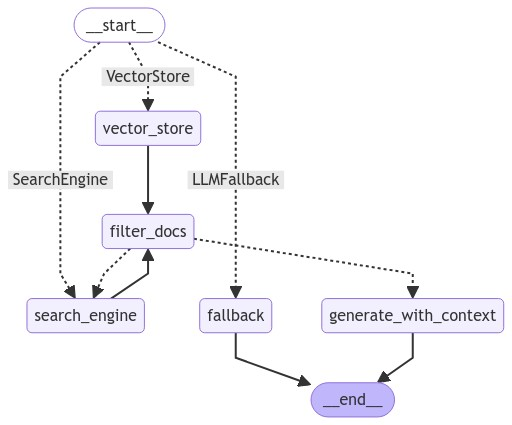

In [46]:
app = workflow.compile(debug=False)
display(Image(app.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API,)))

In [47]:
def send_new_message(query, state=None):
    if state == None:
        state = {}
        state['chat_history'] = []

    response = app.invoke({
        'query': query,
        'chat_history': state['chat_history']
    })

    response['chat_history'] = [HumanMessage(response['query']), AIMessage(response['generation'])]
    return response

In [48]:
state = send_new_message("Hello Atask! I want to know about LSTM")
Markdown(state['generation'])

Hello!

LSTM (Long Short-Term Memory) is a fascinating topic in the realm of Natural Language Processing (NLP). LSTM is a type of Recurrent Neural Network (RNN) architecture that's particularly well-suited for modeling sequential data, such as speech, text, or time series data.

The main advantage of LSTM over traditional RNNs is its ability to learn long-term dependencies in data. This is achieved through the use of memory cells, which allow the network to store information for extended periods of time. This is particularly useful in NLP tasks, where context and relationships between words or tokens can span multiple time steps.

In the context of speech recognition, LSTM is often used as a key component in acoustic models, which aim to predict phonemes or speech sounds from audio inputs. LSTM's ability to capture long-term dependencies helps to improve the accuracy of speech recognition systems.

Some of the key benefits of LSTM include:

1. **Improved performance**: LSTM outperforms traditional RNNs in many NLP tasks, particularly those involving long-range dependencies.
2. **Handling vanishing gradients**: LSTM's memory cells help to mitigate the vanishing gradient problem, which occurs when gradients are backpropagated through time, causing them to shrink exponentially.
3. **Modeling complex patterns**: LSTM is capable of modeling complex patterns and relationships in sequential data, making it a powerful tool for tasks like language modeling, machine translation, and text classification.

Would you like to know more about how LSTM is used in specific NLP tasks, such as language modeling or machine translation?

In [49]:
state = send_new_message("Now I want to know about forgive gate", state)
Markdown(state['generation'])

The "forget gate" is a crucial component of the LSTM architecture.

In an LSTM network, the forget gate is one of the three gates that regulate the flow of information into and out of the memory cell. The forget gate is responsible for deciding what information to discard or "forget" from the previous time step.

The forget gate is a sigmoid neural network layer that takes the previous hidden state and the current input as inputs. It outputs a vector of values between 0 and 1, where 1 indicates "completely remember" and 0 indicates "completely forget". The output of the forget gate is then element-wise multiplied with the previous memory cell state, effectively "forgetting" or removing some information from the memory cell.

The forget gate plays a crucial role in learning long-term dependencies, as it allows the LSTM network to selectively retain or discard information that is no longer relevant. By forgetting some information, the network can focus on the most important aspects of the input data and reduce the impact of irrelevant information.

In the context of speech recognition, the forget gate helps the LSTM network to forget some of the acoustic features that are not relevant for predicting the next phoneme, allowing the network to focus on the most important features that are relevant for accurate speech recognition.

Would you like to know more about the other gates in the LSTM architecture, such as the input gate and the output gate?

In [50]:
state = send_new_message("Now tell me about new mechanisms for gates in LSTM", state)
Markdown(state['generation'])

In recent years, several new mechanisms have been proposed to enhance the functionality of gates in LSTM networks. Here are a few examples:

1. **Gated Recurrent Units (GRUs)**: While not exactly a modification to the LSTM gate, GRUs are a related type of RNN that use gates in a slightly different way. GRUs have two gates: a reset gate and an update gate. The reset gate determines how much of the previous memory to forget, while the update gate determines how much new information to add. GRUs are simpler and faster to train than LSTMs but still capture long-term dependencies effectively.

2. **Coupled Input and Forget Gates**: In traditional LSTMs, the input and forget gates are learned independently. However, some researchers have proposed coupling these gates, so that the forget gate's output is used as an input to the input gate. This coupling helps the network to better balance the amount of information to forget and the amount of new information to add.

3. **Gate Attention Mechanisms**: This mechanism involves adding attention weights to the gates, allowing the network to focus on specific parts of the input sequence when deciding what to remember or forget. This can be particularly useful in speech recognition tasks, where certain acoustic features may be more relevant than others.

4. **Learned Normalize Gate**: This mechanism involves adding a learnable normalization factor to the gates, allowing the network to adjust the scale of the gate outputs. This can help to stabilize the learning process and improve the network's ability to capture long-term dependencies.

5. **Phase-LSTM**: This is a type of LSTM that uses a phase component to modulate the gates. The phase component is a learnable parameter that captures the periodic patterns in the input sequence, allowing the network to better capture long-term dependencies.

6. **Gating Mechanisms with External Memory**: This involves using external memory to store information that can be used to inform the gating mechanism. For example, the network might use an external memory to store information about the context in which a word is being used, and then use this information to decide what to remember or forget.

These are just a few examples of the new mechanisms that have been proposed to enhance the functionality of gates in LSTM networks. Would you like to know more about any of these mechanisms, or is there something else you'd like to explore?